In [1]:
import pandas as pd
import re
df=pd.read_excel("Bengali_News_Headline_Sentiment.xlsx",encoding='utf-8')

In [2]:
df.head()

,News Type,Headline,Sentiment
0,আন্তর্জাতিক,‘১২ মাসের নমনীয়’ সময়ের দিকে যেতে পারে ব্রেক্সিট,1
1,অর্থনীতি,‘২০ রোজার মধ্যে পাটকল শ্রমিকদের মজুরি দিন’,1
2,খেলাধুলা,"‘২০০’ ডাকছে, তামিম রাঙাতে পারবেন তো?",1
3,মতামত,‘২০টি মডেল ভবন তৈরি করে দেখান’,1
4,বাংলাদেশ,‘৬ মাসে ২০৮৩ নারী ও শিশু নির্যাতনের শিকার’,0


In [3]:
df=df.drop('News Type',axis=1)

In [4]:
df['Headline'] = df['Headline'].apply((lambda x: re.sub('[,?'']','',x)))

In [5]:
import numpy as np 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Dense,Embedding,SpatialDropout1D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

Using TensorFlow backend.


In [6]:
max_fatures = 2500
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['Headline'].values)
X = tokenizer.texts_to_sequences(df['Headline'].values)
X = pad_sequences(X)

In [7]:
X

array([[   0,    0,    0, ...,  296,  140,  662],
       [   0,    0,    0, ..., 1292, 1293,  224],
       [   0,    0,    0, ..., 1297,  413,  141],
       ...,
       [   0,    0,    0, ...,  218,   66,  932],
       [   0,    0,    0, ...,   30,  941,   29],
       [   0,    0,    0, ...,    0,    0, 1286]], dtype=int32)

In [8]:
np.shape(X)

(1619, 14)

In [9]:
embed_dim = 64
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['acc'])

In [10]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 64)            160000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 14, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 193,154
Trainable params: 193,154
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
Y = pd.get_dummies(df['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20,random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1295, 14) (1295, 2)
(324, 14) (324, 2)


In [12]:
history=model.fit(X_train, Y_train, epochs = 10, batch_size=32, verbose = 2,validation_split=0.1)

Train on 1165 samples, validate on 130 samples
Epoch 1/10
 - 3s - loss: 0.6271 - acc: 0.6876 - val_loss: 0.6630 - val_acc: 0.6385
Epoch 2/10
 - 1s - loss: 0.6019 - acc: 0.6884 - val_loss: 0.6490 - val_acc: 0.6385
Epoch 3/10
 - 1s - loss: 0.5561 - acc: 0.7004 - val_loss: 0.6378 - val_acc: 0.6615
Epoch 4/10
 - 1s - loss: 0.4218 - acc: 0.8275 - val_loss: 0.6520 - val_acc: 0.6846
Epoch 5/10
 - 1s - loss: 0.2531 - acc: 0.9013 - val_loss: 0.8418 - val_acc: 0.6769
Epoch 6/10
 - 1s - loss: 0.1841 - acc: 0.9330 - val_loss: 0.8713 - val_acc: 0.6615
Epoch 7/10
 - 1s - loss: 0.1356 - acc: 0.9528 - val_loss: 1.1876 - val_acc: 0.6923
Epoch 8/10
 - 1s - loss: 0.1106 - acc: 0.9571 - val_loss: 1.1260 - val_acc: 0.6692
Epoch 9/10
 - 1s - loss: 0.0938 - acc: 0.9665 - val_loss: 1.2785 - val_acc: 0.6385
Epoch 10/10
 - 1s - loss: 0.0746 - acc: 0.9708 - val_loss: 1.3776 - val_acc: 0.6462


In [13]:
score = model.evaluate(X_train, Y_train,
                       batch_size=64, verbose=2)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.18455566513032065
Train accuracy: 0.9482625722885132


In [14]:
score = model.evaluate(X_test, Y_test,
                       batch_size=64, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.02330254919735
Test accuracy: 0.6913580298423767


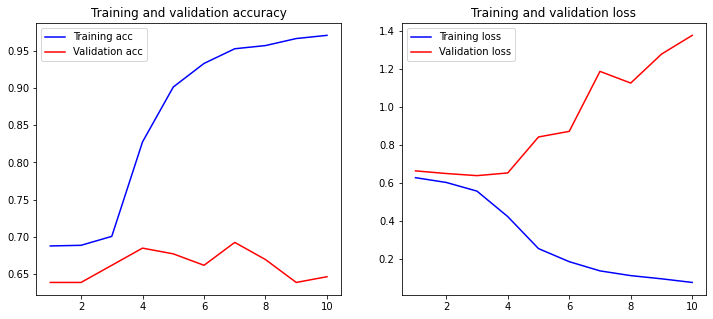

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [16]:
text = input()
text = tokenizer.texts_to_sequences(text)
text = pad_sequences(text,maxlen=14,dtype='int32',value=0)
predict=model.predict(text,batch_size=1,verbose=2)[0]
if(np.argmax(predict)==0):
    print("Negative News")
else:
    print("Positive News")

Positive News
